# Setup

## Imports

In [1408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [1409]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [1410]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [1411]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [1412]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [1413]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [1414]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [1415]:
def hourly(df: pd.DataFrame, prefix: str) -> np.ndarray | None:
    cols = [f"{prefix}_{h}" for h in range(24)]
    valid_cols = [col for col in cols if col in df]

    if not valid_cols:
        return None

    M = df[valid_cols].astype(float).values

    per_hour_median = np.nanmedian(M, axis=0)
    M[np.isnan(M)] = np.take(per_hour_median, np.isnan(M).nonzero()[1])

    # Final global fallback (in case full column is NaN, i think they are not appearing in the dataset btw.)
    if np.isnan(M).any():
        M = np.nan_to_num(M, nan=np.nanmedian(M))

    return M

In [1416]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [1417]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    output = output.drop(columns=['station', 'station_name'])

    return output

In [1418]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Convert string to datetime(with consideration of leap years, making them all to be in 2024) for future use
    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    # Note)
    # Model might falsely interpret the valuse as ordinal or linear(i.e., it may think Febulary is "twice as big" as Jan!)
    # So we are converting them into sin/cos
    # +) considering our target: the next day's temperature anomaly, therefore we would better to use sin/cos for day of year(doy)!
    # We use both sin/cos -> since we want to uniquely represent any position on a cycle! therefore we need 2D coords

    doy = output['date'].dt.dayofyear
    # Dataset is including the leap year -> so we use the average year length(if other better ideas, please post them at the PR!!)
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)

    # solar declination δ (radians)
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    # hour angle at sunrise ω₀ = arccos(−tanφ⋅tanδ)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    # day length in hours = 2·ω₀·(180/π)/15
    day_len = 2 * ω0 * (180.0/np.pi) / 15.0
    output['day_length'] = day_len
    output['day_frac']   = day_len / 24.0

    output = output.drop(columns=['date', 'lat'])

    return output

In [1419]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}'  for h in range(24)]
    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']
    return output

In [1420]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}"   for i in range(24)]
    if not (set(st_cols) <= set(output.columns) and set(dp_cols) <= set(output.columns)):
        return output

    arr_t  = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = (
            output["surface_temp_avg"] - output["climatology_temp"]
        )

    periods = {
        "night": slice(0,  6),
        "morning": slice(6, 12),
        "afternoon": slice(12,18),
        "evening": slice(18,24),
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d
        output[f"temp_dp_interaction_{name}"] = t * d

    return output

In [1421]:
def engineer_dew_depression_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    temp_cols = [f'surface_temp_{h}' for h in range(24)]
    dew_cols  = [f'dew_point_{h}'   for h in range(24)]
    if set(temp_cols).issubset(output.columns) and set(dew_cols).issubset(output.columns):
        dew_dep = output[temp_cols].values - output[dew_cols].values
        output['dew_dep_avg'] = dew_dep.mean(axis=1)
        output['dew_dep_min'] = dew_dep.min(axis=1)
        output['dew_dep_max'] = dew_dep.max(axis=1)
        output['dew_dep_range'] = output['dew_dep_max'] - output['dew_dep_min']

    return output

In [1422]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]
    if set(slp_cols).issubset(output.columns):
        output['pressure_tendency'] = output[slp_cols[-1]] - output[slp_cols[0]]
        output['slp_avg'] = output[slp_cols].mean(axis=1)
    return output

In [1423]:
def engineer_synoptic_combinations(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    eps = 1e-6

    # 1) humidity × (T - Td) => humidity × dew_depression
    if {"humidity_avg", "dew_dep_avg"}.issubset(out.columns):
        out["hum_dep_inter"] = out["humidity_avg"] * out["dew_dep_avg"]

    # 2) pressure tendency × dew depression
    if {"pressure_tendency", "dew_dep_avg"}.issubset(out.columns):
        out["press_dep_inter"] = out["pressure_tendency"] * out["dew_dep_avg"]

    # 3) dew_point × humidity / sea-level pressure
    if {"dew_point_avg", "humidity_avg", "slp_avg"}.issubset(out.columns):
        out["moisture_press_ratio"] = (
                                              out["dew_point_avg"] * out["humidity_avg"]
                                      ) / (out["slp_avg"] + eps)

    # 4) diurnal dew‐point swing × pressure tendency
    if {"dp_evening_avg", "dp_morning_avg", "pressure_tendency"}.issubset(out.columns):
        dp_swing = (out["dp_evening_avg"] - out["dp_morning_avg"]).abs()
        out["dp_swing_press"] = dp_swing * out["pressure_tendency"]

    # 5) triple‐interaction for frontal strength
    if {"humidity_avg","dew_point_avg","pressure_tendency"}.issubset(out.columns):
        out["frontal_strength"] = (
                out["humidity_avg"] * out["dew_point_avg"] * out["pressure_tendency"]
        )

    # 6) Clausius–Clapeyron style exponential moisture
    #    saturation vapor pressure doubles every ~10 °C → e^(0.07×Td)
    if "dew_point_avg" in out.columns:
        out["cc_exp_dp"] = np.exp(0.07 * out["dew_point_avg"])

    return out

In [1424]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    existing = [col for col in drop_cols if col in df.columns]

    output = output.drop(columns=existing)

    return output

In [1425]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_dew_depression_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_synoptic_combinations)
        .pipe(drop_unused_features)
    )

In [1426]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [1427]:
train_df.shape

(13132, 41)

In [1428]:
test_df.shape

(3004, 40)

In [1429]:
train_df

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,...,dew_dep_max,dew_dep_range,pressure_tendency,slp_avg,hum_dep_inter,press_dep_inter,moisture_press_ratio,dp_swing_press,frontal_strength,cc_exp_dp
0,0,-2.707143,-3.992857,115.62,1.721336e-02,0.999852,9.426812,0.392784,-16.808333,46.875000,...,17.2,9.4,-1.9,1034.412500,526.171875,-21.327500,-0.761679,-0.918333,1496.992187,0.308330
1,1,-3.646429,-1.653571,115.62,3.442161e-02,0.999407,9.437325,0.393222,-17.466667,45.500000,...,22.3,15.8,1.1,1035.141667,532.539583,12.874583,-0.767753,0.476667,-874.206667,0.294444
2,2,-2.694643,-0.005357,115.62,5.161967e-02,0.998667,9.448699,0.393696,-17.645833,43.583333,...,22.8,17.0,0.4,1036.045833,537.164583,4.930000,-0.742307,1.146667,-307.625694,0.290774
3,3,-2.501786,-0.898214,115.62,6.880243e-02,0.997630,9.460926,0.394205,-11.966667,53.166667,...,17.8,17.5,-8.7,1031.783333,427.770139,-69.998750,-0.616629,-79.170000,5535.181667,0.432719
4,4,-2.625000,-1.775000,115.62,8.596480e-02,0.996298,9.473997,0.394750,-15.729167,40.583333,...,27.5,28.3,1.6,1027.925000,500.696875,19.740000,-0.621001,8.853333,-1021.347222,0.332525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,-6.880243e-02,0.997630,9.449241,0.393718,-5.366667,63.500000,...,11.5,12.0,4.5,1025.316667,333.110417,23.606250,-0.332369,25.650000,-1533.525000,0.686831
13128,17507,-2.632143,-0.367857,80.09,-5.161967e-02,0.998667,9.455193,0.393966,-11.600000,52.333333,...,13.9,8.3,-3.9,1027.641667,550.808333,-41.047500,-0.590738,-21.320000,2367.560000,0.443969
13129,17508,-1.555357,1.055357,80.09,-3.442161e-02,0.999407,9.462014,0.394251,-11.720833,52.541667,...,14.4,9.4,1.5,1025.562500,546.652257,15.606250,-0.600482,8.700000,-923.748177,0.440230
13130,17509,-2.814286,6.614286,80.09,-1.721336e-02,0.999852,9.469701,0.394571,-5.958333,69.625000,...,7.1,3.4,-1.9,1026.970833,368.432292,-10.054167,-0.403954,-4.908333,788.213021,0.658966


In [1430]:
test_df

,id,climatology_temp,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,dew_humidity_interaction,...,dew_dep_max,dew_dep_range,pressure_tendency,slp_avg,hum_dep_inter,press_dep_inter,moisture_press_ratio,dp_swing_press,frontal_strength,cc_exp_dp
0,0,24.017857,39.81,-0.835925,-0.548843,12.946233,0.539426,21.679167,77.416667,1678.328819,...,8.6,6.0,2.6,1006.504167,381.922222,12.826667,1.667483,0.606667,4363.654931,4.560999
1,1,1.778571,30.59,-0.523416,0.852078,9.580320,0.399180,-5.075000,70.000000,-355.250000,...,11.8,8.2,-4.6,1035.258333,382.375000,-25.127500,-0.343151,-7.360000,1634.150000,0.700998
2,2,24.091071,30.59,-0.111659,-0.993747,14.503336,0.604306,22.141667,87.666667,1941.086111,...,13.2,12.1,-2.3,1007.475000,450.387500,-11.816250,1.926684,-6.210000,-4464.498056,4.711078
3,3,27.076786,30.59,-0.693281,-0.720667,13.466553,0.561106,25.683333,85.708333,2201.275694,...,22.6,20.7,-0.2,1008.579167,674.596007,-1.574167,2.182551,-0.253333,-440.255139,6.036554
4,4,7.417857,30.59,0.970064,0.242850,11.832631,0.493026,-2.470833,60.916667,-150.514931,...,30.6,28.0,1.7,1020.100000,682.012847,19.032917,-0.147549,4.221667,-255.875382,0.841173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,-0.463550,0.886071,9.569618,0.398734,-7.950000,44.291667,-352.118750,...,21.2,14.1,-3.2,1031.400000,477.980903,-34.533333,-0.341399,-3.466667,1126.780000,0.573212
3000,3000,12.312500,30.59,0.999917,-0.012910,12.458907,0.519121,-6.066667,53.791667,-326.336111,...,32.2,28.4,-0.3,1022.941667,680.464583,-3.795000,-0.319017,-0.750000,97.900833,0.653988
3001,3001,27.073214,39.81,-0.393590,-0.919286,14.094582,0.587274,18.466667,75.833333,1400.388889,...,10.0,9.0,0.6,998.325000,256.569444,2.030000,1.402738,1.280000,840.233333,3.642487
3002,3002,18.208929,39.81,0.642055,-0.766659,14.182867,0.590953,14.370833,74.958333,1077.213715,...,27.6,24.8,0.7,1018.345833,801.429514,7.484167,1.057807,0.175000,754.049601,2.734527


<Axes: >

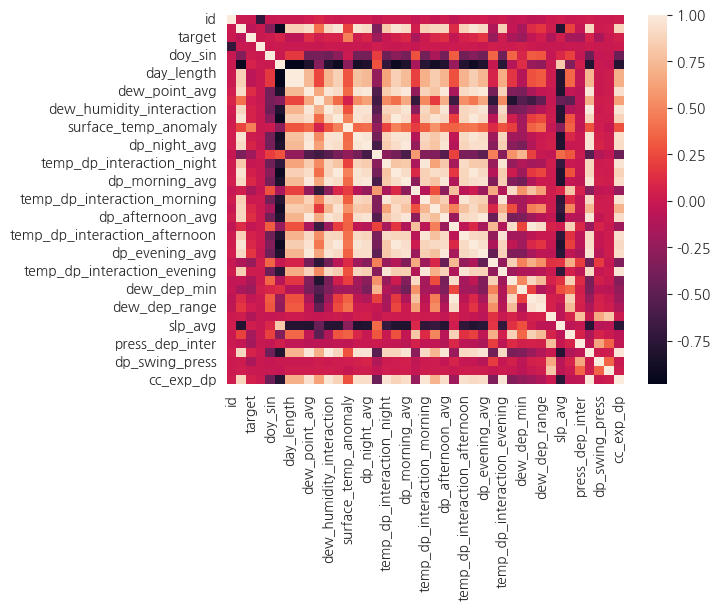

In [1431]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [1432]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)